# Seq2Seq Modeling for Joint Angle Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch import optim
from torch import Tensor
import torch.nn.functional as F
from data_utils import *
from torch_utils import *
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from pathlib import Path
import math, random, time, os
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
torch.manual_seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Management

In [4]:
data_path = Path('../csv-files')
filenames = os.listdir(data_path)

joint_requests = {'Joint' : ['jL5S1','jL4L3','jL1T12','jT9T8','jT1C7','jC1Head',
                             'jRightC7Shoulder','jRightShoulder','jRightElbow','jRightWrist',
                             'jLeftC7Shoulder','jLeftShoulder','jLeftElbow','jLeftWrist',
                             'jRightHip','jRightKnee','jRightAnkle','jRightBallFoot',
                             'jLeftHip','jLeftKnee','jLeftAnkle','jLeftBallFoot']}

In [5]:
positions = None
joint_angles = None
seq_length = 120

for idx, file in enumerate(filenames[:2]):
    joint_target_columns = request_indices(joint_requests)
    print("Index: " + str(idx + 1), end='\r')
    joint_angles_temp = pd.read_csv(data_path / file, 
                                    delimiter=',', 
                                    usecols=joint_target_columns, 
                                    header=0).values
    
    joint_angles_temp = discard_remainder(joint_angles_temp, seq_length)
    if idx == 0:
        joint_angles = joint_angles_temp
    else:
        joint_angles = np.concatenate((joint_angles, joint_angles_temp), axis=0)
        
print("Done with reading files")

joint_angles = joint_angles*(np.pi/180.)

scaler = RobustScaler().fit(joint_angles)
joint_angles = scaler.transform(joint_angles)

print("Number of frames in dataset:", joint_angles.shape[0])
print("Number of bytes:", joint_angles.nbytes)

joint_angles = reshape_to_sequences(joint_angles, seq_length=seq_length) 

Done with reading files
Number of frames in dataset: 537360
Number of bytes: 283726080


In [6]:
encoder_input_data, decoder_target_data = split_sequences(joint_angles, seq_length=seq_length)
del joint_angles

batch_size = 32
encoder_input_data = discard_remainder(encoder_input_data, batch_size)
decoder_target_data = discard_remainder(decoder_target_data, batch_size)

## Refactor using Dataset
------------------------------

PyTorch has an abstract Dataset class.  A Dataset can be anything that has
a ``__len__`` function (called by Python's standard ``len`` function) and
a ``__getitem__`` function as a way of indexing into it.
__[This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)__
walks through a nice example of creating a custom ``FacialLandmarkDataset`` class
as a subclass of ``Dataset``.

PyTorch's __[TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset)__
is a Dataset wrapping tensors. **By defining a length and way of indexing,
this also gives us a way to iterate, index, and slice along the first
dimension of a tensor.** This will make it easier to access both the
independent and dependent variables in the same line as we train.


In [7]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [8]:
encoder_input_data = torch.tensor(encoder_input_data).to(device)
decoder_target_data = torch.tensor(decoder_target_data).to(device)

In [9]:
dataset = TensorDataset(encoder_input_data, decoder_target_data)

train_size_approx = int(0.8 * len(dataset))
train_size = train_size_approx - (train_size_approx % batch_size)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 3552
Number of validation samples: 896


## Zero-Velocity Baseline

In [12]:
def zero_velocity_baseline(data, criterion):
    loss = 0
    
    input_batch, target_batch = data

    seq_length = input_batch.shape[1]
    
    last_input = input_batch[:, -1, :].unsqueeze(0).float()
    
    for t in range(seq_length):
        target = target_batch[:, t, :].unsqueeze(0).float()
        loss += criterion(torch.tensor(scaler.inverse_transform(last_input.squeeze(0).cpu())), 
                          torch.tensor(scaler.inverse_transform(target.squeeze(0).cpu())))
        
    return loss.item() / seq_length

In [13]:
def calculate_zero_velocity_loss(dataloaders, criterion):
    
    train_dataloader, val_dataloader = dataloaders
    
    losses = [zero_velocity_baseline(data, criterion) for _, data in enumerate(train_dataloader, 0)]

    val_losses = [zero_velocity_baseline(data, criterion) for _, data in enumerate(val_dataloader, 0)]

    loss = np.sum(losses) / len(losses)
    val_loss = np.sum(val_losses) / len(val_losses)

    print()
    print("Training Loss: " + str(loss), "Val Loss: " + str(val_loss))

## Seq2Seq Model

### Encoder

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, dropout=0.0, bidirectional=False):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.bidirectional = bidirectional

        self.gru = nn.GRU(input_size, hidden_size, bidirectional=bidirectional)
        
        if self.bidirectional:
            self.fc = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, input):
        output, hidden = self.gru(input)
        
        if self.bidirectional:
            hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))).unsqueeze(0)
        
        return output, hidden

### Decoder

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.gru = nn.GRU(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = self.out(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

## Seq2Seq Model with Attention

Modified from __[here](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)__ and __[here](https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53)__, which are great tutorials on different seq2seq models and attention. The Attention module uses Luong et al. This is also known as "general" attention.

### Attention Module

In [16]:
class Attention(nn.Module):
    def __init__(self, hidden_size, batch_size, method, bidirectional_encoder=False):
        super().__init__()
        
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.method = method
        self.directions = 1
        
        if bidirectional_encoder:
            self.directions = 2
        
        if method == 'dot':
            pass
        elif method == 'general':
            self.Wa = nn.Linear(hidden_size, self.directions*hidden_size, bias=False)
        elif method == 'concat':
            self.Wa = nn.Linear((2*hidden_size) + hidden_size, hidden_size, bias=False)
            self.va = nn.Parameter(torch.rand(hidden_size))
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [1, batch_size, hidden_size]
        #encoder_outputs = [seq_len, batch_size, 2*hidden_size]
        
        assert self.batch_size == encoder_outputs.shape[1]
        self.seq_len = encoder_outputs.shape[0]
        
        hidden = hidden.squeeze(0)
        #hidden = [batch_size, hidden_size]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch_size, seq_len, 2*hidden_size]
        
        score = self._score(hidden, encoder_outputs)
        #score = [batch_size, seq_len]
        
        return F.softmax(score, dim=1)
    
    def _score(self, hidden, encoder_outputs):
        """
        Computes an attention score
        :param hidden: (batch_size, hidden_dim)
        :param encoder_outputs: (batch_size, seq_len, hidden_dim)
        :return: a score (batch_size, seq_len)
        """
        
        if self.method == 'dot':
            hidden = hidden.unsqueeze(-1)
            hidden = hidden.repeat(1, self.directions, 1)
            score = encoder_outputs.bmm(hidden).squeeze(-1)
            return score

        elif self.method == 'general':
            x = self.Wa(hidden)
            x = x.unsqueeze(-1)
            score = encoder_outputs.bmm(x).squeeze(-1)
            return score

        elif self.method == 'concat':
            hidden = hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
            energy = torch.tanh(self.Wa(torch.cat((hidden, encoder_outputs), 2)))
            energy = energy.permute(0, 2, 1)
            va = self.va.repeat(self.batch_size, 1).unsqueeze(1)
            score = torch.bmm(va, energy).squeeze(1)
            return score

### Attention Decoder

In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, output_dim, features_dim, enc_hidden_size, dec_hidden_size, attention, bidirectional_encoder=False):
        super().__init__()
        
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.output_dim = output_dim
        self.features_dim = features_dim
        self.attention = attention
        
        self.directions = 1
        if bidirectional_encoder:
            self.directions = 2

        
        self.rnn = nn.GRU(self.directions*enc_hidden_size + features_dim, dec_hidden_size)
        
        self.out = nn.Linear(self.directions*enc_hidden_size + dec_hidden_size + features_dim, output_dim)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [1, batch size, enc hid dem]
        #hidden = [1, batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, seq len, enc hid dim]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim]
        
        rnn_input = torch.cat((input, weighted), dim = 2)
        
        #rnn_input = [1, batch size, enc hid dim + hid dim]
        
        output, hidden = self.rnn(rnn_input, hidden)
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        input = input.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, input), dim = 1))
        
        #output = [bsz, output dim]
        
        return output.unsqueeze(0), hidden

## Training

In [51]:
def loss_batch(data, models, opts, criterion, teacher_forcing_ratio=0.0, use_attention=False):
    encoder, decoder = models
    input_batch, target_batch = data
    
    if opts is not None:
        encoder_opt, decoder_opt = opts
    
    loss = 0
    scaled_loss = 0        
    seq_length = input_batch.shape[1]

    input = input_batch.permute(1, 0, 2).float()
    encoder_outputs, encoder_hidden = encoder(input)

    decoder_hidden = encoder_hidden
    decoder_input = torch.ones_like(target_batch[:, 0, :]).unsqueeze(0).float()
    EOS = torch.zeros_like(target_batch[:, 0, :]).unsqueeze(0).float()

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    for t in range(seq_length):
        
        if use_attention:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        else:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
        target = target_batch[:, t, :].unsqueeze(0).float()
        
        loss += criterion(decoder_output, target)
        
        if opts is None:
            scaled_loss += criterion(torch.tensor(scaler.inverse_transform(decoder_output.squeeze(0).cpu())), 
                                     torch.tensor(scaler.inverse_transform(target.squeeze(0).cpu())))
        
        if use_teacher_forcing:
            decoder_input = target
        else:
            if torch.all(torch.eq(decoder_output, EOS)):
                break
            decoder_input = decoder_output.detach()

    if opts is not None:
        loss.backward()
        
        encoder_opt.step()
        encoder_opt.zero_grad()

        decoder_opt.step()
        decoder_opt.zero_grad()
    else:
        scaled_loss = scaled_loss.item() / seq_length
    
    return loss.item() / seq_length, scaled_loss

In [52]:
def fit(models, opts, epochs, dataloaders, criterion, 
        teacher_forcing_ratio=0.0, 
        update_learning_rates=None, 
        use_attention=False,
        schedule_rate=1.0):
    
    train_dataloader, val_dataloader = dataloaders
    
    plot_losses = []
    for epoch in range(epochs):
        losses = []
        train_total_time = 0
        
        if update_learning_rates is not None:
            opts = update_learning_rates(opts, epoch)
            
        print("Epoch", str(epoch+1) + "/" + str(epochs))
        
        for index, data in enumerate(train_dataloader, 0):
            batch_size = len(data[0])
            
            start_time = time.time()
            
            loss, _ = loss_batch(data, models, 
                         opts, criterion,
                         use_attention=use_attention) 
            
            losses.append(loss)
            
            end_time = time.time()
            total_time += end_time - start_time
            
            amount_complete = math.floor((index + 1) / len(train_dataloader) * 30)
            amount_incomplete = (30 - amount_complete)
            progress_bar = "[" + amount_complete*"=" + amount_incomplete*"-" + "]"
            
            print("%d/%d" % (batch_size*(index+1), batch_size*len(train_dataloader)),
                  progress_bar, 
                  "- Time elapsed: %.2fs" % total_time, 
                  "- Loss: %.8f" % loss, 
                  end="\r"
                 )
            
        with torch.no_grad():
            val_losses, scaled_val_losses = zip(
                                            *[loss_batch(data, models, None, criterion, use_attention=use_attention) 
                                            for _, data in enumerate(val_dataloader, 0)]
            )
            
        loss = np.sum(losses) / len(losses)
        val_loss = np.sum(val_losses) / len(val_losses)
        scaled_val_loss = np.sum(scaled_val_losses) / len(scaled_val_losses)
        
        plot_losses.append((loss, val_loss))
        
        print()
        print("Training Loss: %.8f - Val Loss: %.8f - Scaled Val Loss: %.8f" % (loss, val_loss, scaled_val_loss))
        
        teacher_forcing_ratio *= schedule_rate
    
    showPlot(plot_losses, epochs)

In [20]:
def update_learning_rates(opts, epoch, schedule=0.9):
    if (epoch + 1) == 5:
        for opt in opts:
            for param_group in opt.param_groups:
                param_group['lr'] *= (1 - schedule**(epoch+1))
            
    return opts

In [21]:
def get_encoder(num_features, hidden_size=64, lr=0.001, bs=batch_size, bidirectional=False):
    encoder = EncoderRNN(num_features, hidden_size, bs, bidirectional=bidirectional).to(device)
    return encoder, optim.Adam(encoder.parameters(), lr=lr)

def get_decoder(num_features, hidden_size=64, lr=0.001, bs=batch_size):
    decoder = DecoderRNN(num_features, hidden_size, num_features, bs).to(device)
    return decoder, optim.Adam(decoder.parameters(), lr=lr)

def get_attn_decoder(num_features, method, hidden_size=64, lr=0.001, bs=batch_size, bidirectional_encoder=False):
    attn = Attention(hidden_size, bs, method, bidirectional_encoder=bidirectional_encoder)
    decoder = AttnDecoderRNN(num_features, num_features, hidden_size, hidden_size, attn, bidirectional_encoder=bidirectional_encoder).to(device)
    return decoder, optim.Adam(decoder.parameters(), lr=lr)

In [22]:
def showPlot(points, epochs):
    points = np.array(points)
    plt.figure()
    fig, ax = plt.subplots()
    x = range(1, epochs+1)
    plt.plot(x, points[:,0], 'b-')
    plt.plot(x, points[:,1], 'r-')
    plt.legend(['training loss', 'val loss'])

In [23]:
epochs = 15

dataloaders = (train_dataloader, val_dataloader)

criterion = nn.L1Loss()

## Zero-velocity baseline

In [24]:
calculate_zero_velocity_loss(dataloaders, criterion)


Training Loss: 0.03529511859962112 Val Loss: 0.03457983762791939


## Training the seq2seq model

Epoch 1/15
3552/3552 [==============================] - Time elapsed: 7.61s - Loss: 2.87316640
Training Loss: 3.71708545 - Val Loss: 3.62100264 - Scaled Val Loss: 0.10692508
Epoch 2/15
3552/3552 [==============================] - Time elapsed: 7.58s - Loss: 4.64502004
Training Loss: 3.57999315 - Val Loss: 3.51871664 - Scaled Val Loss: 0.08271593
Epoch 3/15
3552/3552 [==============================] - Time elapsed: 7.54s - Loss: 2.29161987
Training Loss: 3.51133962 - Val Loss: 3.47447519 - Scaled Val Loss: 0.07407686
Epoch 4/15
3552/3552 [==============================] - Time elapsed: 7.55s - Loss: 2.45678431
Training Loss: 3.47170195 - Val Loss: 3.44481716 - Scaled Val Loss: 0.06937893
Epoch 5/15
3552/3552 [==============================] - Time elapsed: 7.56s - Loss: 2.50452118
Training Loss: 3.44433006 - Val Loss: 3.41823026 - Scaled Val Loss: 0.06544751
Epoch 6/15
3552/3552 [==============================] - Time elapsed: 7.86s - Loss: 3.21036504
Training Loss: 3.41962044 - Val Los

<Figure size 432x288 with 0 Axes>

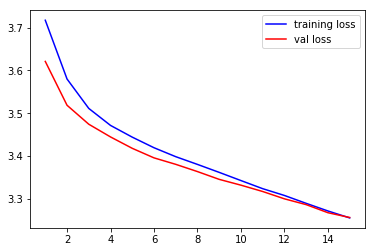

In [54]:
encoder, encoder_opt = get_encoder(66)
decoder, decoder_opt = get_decoder(66)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion)

## Training the seq2seq model with a bidirectional encoder

Epoch 1/15
6368/6368 [==============================] - Time: 8.67s - Loss: 0.40367654164632165
Training Loss: 0.49831792377746686 - Val Loss: 0.38531674766540536 - Scaled Val Loss: 0.1003493676088363
Epoch 2/15
6368/6368 [==============================] - Time: 8.18s - Loss: 0.32493263880411787
Training Loss: 0.3395570895579991 - Val Loss: 0.31397492027282714 - Scaled Val Loss: 0.0805495836825003
Epoch 3/15
6368/6368 [==============================] - Time: 8.24s - Loss: 0.28481508890787765
Training Loss: 0.29490614736100135 - Val Loss: 0.2851898959477742 - Scaled Val Loss: 0.07251643977079714
Epoch 4/15
6368/6368 [==============================] - Time: 8.49s - Loss: 0.27361691792805993
Training Loss: 0.2708202454712323 - Val Loss: 0.265952641805013 - Scaled Val Loss: 0.06713984170491118
Epoch 5/15
6368/6368 [==============================] - Time: 8.49s - Loss: 0.26088457107543944
Training Loss: 0.2523286293898795 - Val Loss: 0.2548425184885661 - Scaled Val Loss: 0.06402482431627077

<Figure size 432x288 with 0 Axes>

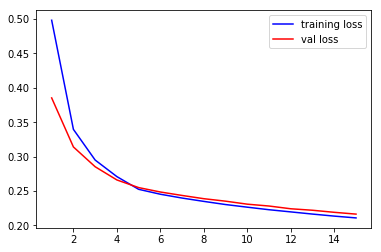

In [75]:
encoder, encoder_opt = get_encoder(66, bidirectional=True)
decoder, decoder_opt = get_decoder(66)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, update_learning_rates=update_learning_rates)

## Training the seq2seq model with attention

Epoch 1/15
6368/6368 [==============================] - Time: 13.03s - Loss: 0.28657741546630867
Training Loss: 0.3844551008151005 - Val Loss: 0.3059776973724365 - Scaled Val Loss: 0.07617483466081483
Epoch 2/15
6368/6368 [==============================] - Time: 12.89s - Loss: 0.23324629465738933
Training Loss: 0.2792498328178572 - Val Loss: 0.25958847173055016 - Scaled Val Loss: 0.06293677614934134
Epoch 3/15
6368/6368 [==============================] - Time: 12.90s - Loss: 0.24156084060668945
Training Loss: 0.24673716323060207 - Val Loss: 0.2362577997843425 - Scaled Val Loss: 0.056540121402971745
Epoch 4/15
6368/6368 [==============================] - Time: 12.94s - Loss: 0.22435520490010582
Training Loss: 0.22793481641478675 - Val Loss: 0.2206785415013631 - Scaled Val Loss: 0.05197896302965086
Epoch 5/15
6368/6368 [==============================] - Time: 12.93s - Loss: 0.19855694770812987
Training Loss: 0.21371006470429438 - Val Loss: 0.20992007382710776 - Scaled Val Loss: 0.0490761

<Figure size 432x288 with 0 Axes>

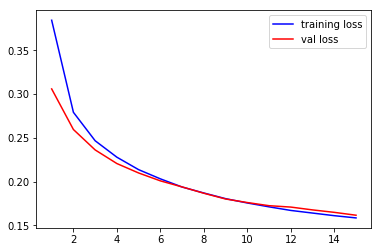

In [78]:
encoder, encoder_opt = get_encoder(66)
decoder, decoder_opt = get_attn_decoder(66, 'general')

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, use_attention=True)

## Training the seq2seq model with bidirectional encoder and attention

Epoch 1/15
6368/6368 [==============================] - Time: 14.14s - Loss: 0.27742211023966473
Training Loss: 0.3394775181359781 - Val Loss: 0.25211158275604245 - Scaled Val Loss: 0.06133185112066971
Epoch 2/15
6368/6368 [==============================] - Time: 13.87s - Loss: 0.20340992609659832
Training Loss: 0.22660876526505103 - Val Loss: 0.20745236206054693 - Scaled Val Loss: 0.04804651035332627
Epoch 3/15
6368/6368 [==============================] - Time: 13.92s - Loss: 0.17401712735493977
Training Loss: 0.1974703688118326 - Val Loss: 0.18962123648325602 - Scaled Val Loss: 0.04358815335272571
Epoch 4/15
6368/6368 [==============================] - Time: 13.94s - Loss: 0.16357041994730637
Training Loss: 0.18381139189753698 - Val Loss: 0.17921684424082435 - Scaled Val Loss: 0.04059808719323813
Epoch 5/15
6368/6368 [==============================] - Time: 13.90s - Loss: 0.17062155405680338
Training Loss: 0.17437058864925775 - Val Loss: 0.17261907196044923 - Scaled Val Loss: 0.03904

<Figure size 432x288 with 0 Axes>

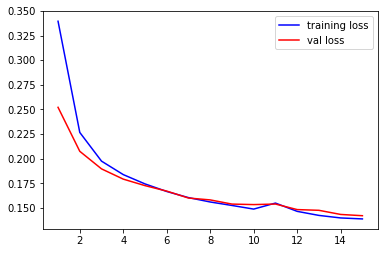

In [79]:
encoder, encoder_opt = get_encoder(66, bidirectional=True)
decoder, decoder_opt = get_attn_decoder(66, 'general', bidirectional_encoder=True)

models = (encoder, decoder)
opts = (encoder_opt, decoder_opt)

fit(models, opts, epochs, dataloaders, criterion, use_attention=True)